# Explore GEMMA and comparison with BulkLMM.jl

In this interactive notebook, we will explore the usage of GEMMA package, the methods behind the implementation, its performance running on the BXD data, as compared with the BulkLMM.jl package in Julia. 


This is still a work in progress, as here only the use of GEMMA for association tests with **univariate linear mixed models** will be talked about...

In [14]:
pwd()

"/Users/zifanyu/Documents/GitHub/BulkLMM.jl/test"

In [15]:
cd("..")

In [5]:
include("BXDdata_for_test.jl");

In [6]:
(n, m, p)

(79, 35556, 7321)

In [7]:
size(pheno)

(79, 35556)

In [9]:
size(geno)

(79, 7321)

In [8]:
size(kinship)

(79, 79)

## How to... 

### Cite GEMMA:

- Software tool and univariate linear mixed models
Xiang Zhou and Matthew Stephens (2012). Genome-wide efficient mixed-model analysis for association studies. Nature Genetics. 44: 821-824.

- Multivariate linear mixed models
Xiang Zhou and Matthew Stephens (2014). Efficient multivariate linear mixed model algo- rithms for genome-wide association studies. Nature Methods. 11: 407-409.

- Bayesian sparse linear mixed models
Xiang Zhou, Peter Carbonetto and Matthew Stephens (2013). Polygenic modeling with Bayesian sparse linear mixed models. PLoS Genetics. 9(2): e1003264.

- Variance component estimation with individual-level or summary data
Xiang Zhou (2016). A unified framework for variance component estimation with summary statistics in genome-wide association studies. bioRxiv. 042846.

### Install and Setup GEMMA:

It is recommended to install precompiled binaries of GEMMA and use on a linux system.

1. Fetch the latest [stable release](https://github.com/genetics-statistics/GEMMA/releases) and download the .gz file.

2. Inside the directory where the .gz file is located, run `gunzip gemma.linux.gz` to unpack the file.

3. Make sure it is executable with `chomod u+x gemma-linux` and then execute with `gemma-linux`. 

4. Run GEMMA by first typing `alias gemma=path to gemma executable` and then it will be envoked by simply typing `gemma` in terminal.

Run `alias gemma=path to gemma executable` so that the GEMMA program will start by just typing `gemma` in terminal.

Here inside this notebook, we did something similar to creating an alias shortcut by

In [18]:
cd("run-gemma")

In [19]:
pwd()

"/Users/zifanyu/Documents/GitHub/BulkLMM.jl/test/run-gemma"

In [20]:
gemma = "/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64"

"/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64"

and testing GEMMA set up by

In [13]:
run(`$gemma -h`)

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021

 type ./gemma -h [num] for detailed help
 options: 
  1: quick guide
  2: file I/O related
  3: SNP QC
  4: calculate relatedness matrix
  5: perform eigen decomposition
  6: perform variance component estimation
  7: fit a linear model
  8: fit a linear mixed model
  9: fit a multivariate linear mixed model
 10: fit a Bayesian sparse linear mixed model
 11: obtain predicted values
 12: calculate snp variance covariance
 13: note
 14: debug options

The GEMMA software is distributed under the GNU General Public v3
   -license    show license information
   see also http://www.xzlab.org/software.html, https://github.com/genetics-statistics


Process(`/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64 -h`, ProcessExited(0))

## Input File Formats:

It is recommended to use [BIMBAM](https://stephenslab.uchicago.edu/software.html) (Bayesian Imputation Based Association Mapping) file format for imputed genotypes as well as for general covariates other than SNPs. BIMBAM format consists of three files, a mean genotype file, a phenotype file, and an optional SNP annotation file, which we will explain in detail below.

(We first run `gemma-generateData.jl` to generate BIMBAM format genotype data from origional. For he univariate trait data we picked the 7919-th column of the original BXD phenotype data)

In [27]:
# Create variables for shortcut references to the datafiles:
pheno_filename = "BXDpheno_bimbam.txt";
geno_filename = "BXDgeno_prob_bimbam.txt";

### Mean Genotype File

In [28]:
readdlm(geno_filename, ',')[1:6, :]

6×82 Matrix{Any}:
 "rs31443144"   "A"  "B"  2.0  2.0  1.03617e-10  …  2.0  2.0  2.0  2.0  2.0
 "rs6269442"    "A"  "B"  2.0  2.0  1.03617e-10     2.0  2.0  2.0  2.0  2.0
 "rs32285189"   "A"  "B"  2.0  2.0  4.9563e-13      2.0  2.0  2.0  2.0  2.0
 "rs258367496"  "A"  "B"  2.0  2.0  4.9563e-13      2.0  2.0  2.0  2.0  2.0
 "rs32430919"   "A"  "B"  2.0  2.0  4.95576e-9      2.0  2.0  2.0  2.0  2.0
 "rs36251697"   "A"  "B"  2.0  2.0  5.36709e-9   …  2.0  2.0  2.0  2.0  2.0

In [29]:
size(readdlm(geno_filename, ','))

(7321, 82)

The mean genotype file is like the above, where the first column is SNP id, the second and third column are allele types with minor allele first, and the remaining columns are the posterior/imputed mean genotypes of different individuals numbered from 0 and 2.

GEMMA codes alleles exactly as provided in the mean genotype file, and ignores the allele types given in the second and third columns. Therefore, the minor allele is the effect allele only if it is coded as 1 and the major allele is coded as 0. Missing genotypes are represented as "NA" values.

In our BXD data examples, we have two SNPs, "A" being the minor allele and "B" being the major allele, and observations at 7321 marker places for the 79 individuals. Therefore, as shown in the data, each row are the observations of frequencies of the minor allele "A" for the 79 individuals at a certain marker place, and each column are the observations of the "A" frequencies at the 7321 marker places for a certain individual.

### Phenotype File

In [30]:
readdlm(pheno_filename, ',')[1:6]

6-element Vector{Float64}:
 10.715
 10.792
 11.968
 11.56
 11.097
 10.85

In [31]:
size(readdlm(pheno_filename, ','))

(79, 1)

For univariate trait BIMBAM data, it just one column of phenotype values of the 79 strains.

For binary traits, it is recommended to label controls as 0 and cases as 1 for better interpretation of the results.

### Relatedness Matrix File Format

### Original Matrix Format

Two formats of kinship matrix in the original matrix form allowed by GEMMA are as shown below:

In [37]:
example1_K = reshape([0.3345  -0.0227   0.0103 -0.0227  0.3032  -0.0253 0.0103  -0.0253   0.3531], 3, 3)

3×3 Matrix{Float64}:
  0.3345  -0.0227   0.0103
 -0.0227   0.3032  -0.0253
  0.0103  -0.0253   0.3531

In [38]:
example2_K = df = DataFrame(column_1 = ["id1", "id1", "id1", "id2", "id2", "id3"], 
               column_2 = ["id1", "id2", "id3", "id2", "id3", "id3"],
               column_3 = [0.3345, -0.0227, 0.0103, 0.3032,  -0.0253, 0.3531])

,column_1,column_2,column_3
,String,String,Float64
1,id1,id1,0.3345
2,id1,id2,-0.0227
3,id1,id3,0.0103
4,id2,id2,0.3032
5,id2,id3,-0.0253
6,id3,id3,0.3531


Two example kinship matrix formats allowed are as shown above, for three individuals. One can use `-km [num]` to choose which format to use, i.e. use `km -1` to accompany BIMBAM format.

## Models

### Estimate Relatedness Matrix from Genotypes

#### Basic Usage

`gemma -g [genotype file name] -p [phenotype file name] -gk [num: 1 for G_centered, 2 for G_standardized] -o [output prefix]`

In [34]:
@time run(`$gemma -g $geno_filename -p $pheno_filename -gk 1 -o kinship`)

LoadError: IOError: could not spawn `/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64 -g BXDgeno_prob_bimbam.txt -p BXDpheno_bimbam.txt -gk 1 -o kinship`: no such file or directory (ENOENT)

#### Detailed Information

$$G_c = \frac{1}{p}\sum_{i=1}^p(x_i -1_n \bar x_i)(x_i - 1_n \bar x_i)^T$$

$$G_s = \frac{1}{p}\sum_{i=1}^p\frac{1}{v_{x_i}}(x_i -1_n \bar x_i)(x_i - 1_n \bar x_i)^T$$

Which of the two relatedness matrix to choose will largely depend on the underlying genetic archi- tecture of the given trait. Specifically, if SNPs with lower minor allele frequency tend to have larger effects (which is inversely proportional to its genotype variance), then the standardized genotype matrix is preferred. If the SNP effect size does not depend on its minor allele frequency, then the centered genotype matrix is preferred.

### Univariate Linear Mixed Models

#### Basic Usage

`gemma -g [filename] -p [filename] -a [(optional) SNP annotation] -k [relatedness matrix file name] -lmm [1 for Wald test, 2 for LR test, 3 for score test, 4 for all three tests] -o [prefix]`

In [35]:
pwd()

"/Users/zifanyu/Documents/GitHub/BulkLMM.jl/test/run-gemma"

In [8]:
@time run(`$gemma -g $geno_filename -p $pheno_filename -k output/kinship.cXX.txt -lmm 2 -o gemma_results.txt`)

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 79
## number of analyzed individuals = 79
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =     7321
## number of analyzed SNPs         =     7321
Start Eigen-Decomposition...
pve estimate =0.813567
se(pve) =0.0950615
================================================== 100%
  1.170007 seconds (12.73 k allocations: 722.434 KiB, 1.54% compilation time)


**** INFO: Done.


Process(`/home/xyu/software/GEMMA/gemma-0.98.5-linux-static-AMD64 -g /home/xyu/github/BulkLMM.jl/test/run-gemma/BXDgeno_prob_bimbam.txt -p /home/xyu/github/BulkLMM.jl/test/run-gemma/BXDpheno_bimbam.txt -k output/kinship.cXX.txt -lmm 1 -o gemma_results.txt`, ProcessExited(0))

#### Output Files:

There will be two optput files, both inside a folder named 'output' (auto-created) in the current directory:

- The 'pre-fix.log.txt' file contains some detailed information about the running parameters and computation time,

In [93]:
logreport_gemma = CSV.read("output/gemma_results.txt.log.txt", DataFrame, delim = '\t', header = false)

,Column1
,String
1,##
2,## GEMMA Version = 0.98.5 (2021-08-25)
3,## Build profile = /gnu/store/8rvid272yb53bgascf5c468z0jhsyflj-profile
4,## GCC version = 7.5.0
5,## GSL Version = 2.6
6,## OpenBlas = OpenBLAS 0.3.9 - OpenBLAS 0.3.9 DYNAMIC_ARCH NO_AFFINITY Haswell MAX_THREADS=128
7,## arch = Haswell
8,## threads = 32
9,## parallel type = threaded


In [87]:
results_gemma = CSV.read("output/gemma_results.txt.assoc.txt", DataFrame, delim = '\t', header = false);

In [90]:
results_gemma[1:6, 1:8]

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,String3,String31,String3,String7,String7,String7,String7,String15
1,chr,rs,ps,n_miss,allele1,allele0,af,beta
2,-9,rs31443144,-9,0,A,B,0.557,-1.208557e-02
3,-9,rs6269442,-9,0,A,B,0.557,-1.208557e-02
4,-9,rs32285189,-9,0,A,B,0.557,-1.208557e-02
5,-9,rs258367496,-9,0,A,B,0.557,-1.208557e-02
6,-9,rs32430919,-9,0,A,B,0.557,-1.208557e-02


In [91]:
results_gemma[1:6, 9:12]

,Column9,Column10,Column11,Column12
,String15,String15,String15,String15
1,se,logl_H1,l_remle,p_wald
2,6.403611e-02,-4.987721e+01,4.510609e+00,8.508005e-01
3,6.403611e-02,-4.987721e+01,4.510609e+00,8.508005e-01
4,6.403611e-02,-4.987721e+01,4.510609e+00,8.508005e-01
5,6.403611e-02,-4.987721e+01,4.510609e+00,8.508005e-01
6,6.403611e-02,-4.987721e+01,4.510609e+00,8.508005e-01


Full results reported by GEMMA has the format as shown above:

In [95]:
unique(results_gemma[:, 1])

2-element Vector{String3}:
 "chr"
 "-9"

#### Using the kinship matrix $G_c$ calculated by *GEMMA* using the above formula:

In [39]:
kinship_Gc = CSV.read("output/kinship.cXX.txt", DataFrame, delim = '\t', header = false);

In [40]:
kinshipMat_Gc = Matrix(kinship_Gc);

In [43]:
kinshipMat_Gc[1:6, 1:6]

6×6 Matrix{Float64}:
  0.971367    -0.0803409   0.118316    0.0516335  -0.00965022  -0.0889471
 -0.0803409    0.991482   -0.0287038   0.0275875  -0.141933    -0.0646924
  0.118316    -0.0287038   1.01951    -0.217635   -0.103393     0.116334
  0.0516335    0.0275875  -0.217635    1.04452     0.177017    -0.0793848
 -0.00965022  -0.141933   -0.103393    0.177017    0.996395    -0.0755602
 -0.0889471   -0.0646924   0.116334   -0.0793848  -0.0755602    0.943166

In [57]:
results_bulklmm_alt = scan(pheno_y, geno, kinshipMat_Gc; reml = false, method = "alt");

In [48]:
results_bulklmm_null = scan(pheno_y, geno, kinshipMat_Gc; reml = true, method = "null");

In [58]:
results_bulklmm_null[2] # hsq under the null model estimated by BulkLMM, using reml = true

0.8182834394427059

In [94]:
0.221055/(0.221055+0.0490897)

0.8182836827818573

#### Using the kinship matrix calculated by *BulkLMM.jl*:

In [74]:
kinshipMat_bulklmm = kinship;
kinshipMat_bulklmm[1:6, 1:6]

6×6 Matrix{Float64}:
 1.0       0.468763  0.561085  0.521296  0.502617  0.476443
 0.468763  1.0       0.482652  0.50435   0.431553  0.483647
 0.561085  0.482652  1.0       0.374733  0.443817  0.567154
 0.521296  0.50435   0.374733  1.0       0.577574  0.462847
 0.502617  0.431553  0.443817  0.577574  1.0       0.476722
 0.476443  0.483647  0.567154  0.462847  0.476722  1.0

In [75]:
results_bulklmm2_alt = scan(pheno_y, geno, kinshipMat_BulkLMM; reml = false, method = "alt");

In [76]:
results_bulklmm2_null = scan(pheno_y, geno, kinshipMat_BulkLMM; reml = true, method = "null");

In [77]:
results_bulklmm2_null[2] # hsq under the null model estimated by BulkLMM, using reml = true

0.9010989589597949

In [78]:
using Plots

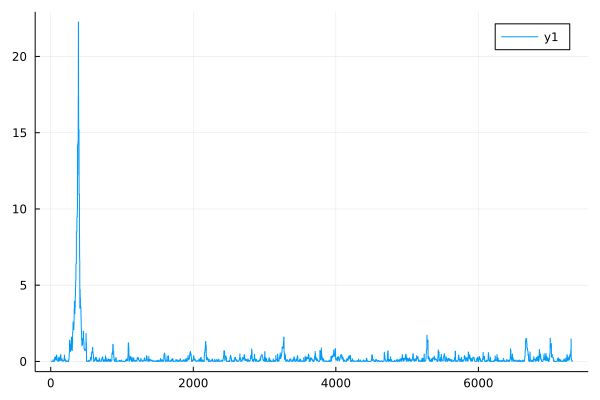

In [79]:
plot(results_bulklmm_null[3])

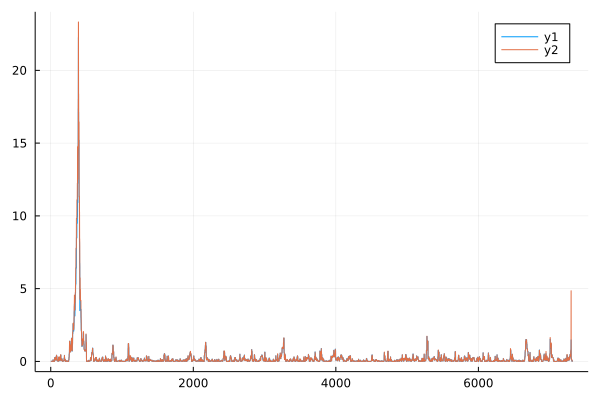

In [80]:
plot!(results_bulklmm_alt[3])

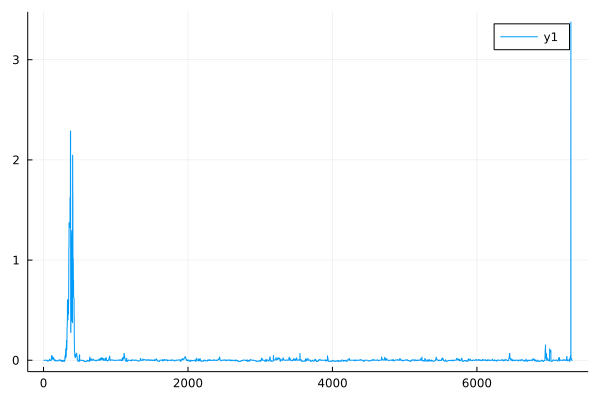

In [81]:
plot(results_bulklmm_alt[3] .- results_bulklmm_null[3])